In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from statannotations.Annotator import Annotator
from petTOAD_load import *
from petTOAD_group_level_analysis import n_simulations, load_df_arrays

Getting the layout...
Done with the layout...
The following patients were discarded for having ROIs with all zeros: []
petTOAD Setup done!


In [2]:
def _get_share_ax(share_var, axarr, row, col):
    "From: https://wil.yegelwel.com/subplots-with-row-titles/"
    if share_var == "row":
        if col > 0:
            return axarr[row, col - 1]
        return None
    elif share_var == "col":
        if row > 0:
            return axarr[row - 1, col]
        return None
    elif share_var and (col > 0 or row > 0):
        return axarr[0, 0]
    return None


def subplots_with_row_titles(
    nrows,
    ncols,
    row_titles=None,
    row_title_kw=None,
    sharex=False,
    sharey=False,
    subplot_kw=None,
    grid_spec_kw=None,
    **fig_kw,
):
    """
    Creates a figure and array of axes with a title for each row.
    From: https://wil.yegelwel.com/subplots-with-row-titles/
    Parameters
    ----------
    nrows, ncols : int
        Number of rows/columns of the subplot grid
    row_titles : list, optional
        List of titles for each row. If included, there must be one title for each row.
    row_title_kw: dict, optional
        Dict with kewords passed to the `~matplotlib.Axis.set_title` function.
        A common use is row_title_kw={'fontsize': 24}
    sharex, sharey : bool or {'none', 'all', 'row', 'col'}, default: False
        Controls sharing of properties among x (*sharex*) or y (*sharey*)
        axes:

        - True or 'all': x- or y-axis will be shared among all subplots.
        - False or 'none': each subplot x- or y-axis will be independent.
        - 'row': each subplot row will share an x- or y-axis.
        - 'col': each subplot column will share an x- or y-axis.

        When subplots have a shared x-axis along a column, only the x tick
        labels of the bottom subplot are created. Similarly, when subplots
        have a shared y-axis along a row, only the y tick labels of the first
        column subplot are created. To later turn other subplots' ticklabels
        on, use `~matplotlib.axes.Axes.tick_params`.
    subplot_kw : dict, optional
        Dict with keywords passed to the
        `~matplotlib.figure.Figure.add_subplot` call used to create each
        subplot.
    gridspec_kw : dict, optional
        Dict with keywords passed to the `~matplotlib.gridspec.GridSpec`
        constructor used to create the grid the subplots are placed on.
    **fig_kw
        All additional keyword arguments are passed to the
        `.pyplot.figure` call.
    """
    if row_titles is not None and len(row_titles) != nrows:
        raise ValueError(
            f"If row_titles is specified, there must be one for each row. Got={row_titles}"
        )
    if subplot_kw is None:
        subplot_kw = {}
    if row_title_kw is None:
        row_title_kw = {}
    if sharex not in {True, False, "row", "col"}:
        raise ValueError(
            f'sharex must be one of [True, False, "row", "col"]. Got={sharex}'
        )
    if sharey not in {True, False, "row", "col"}:
        raise ValueError(
            f'sharey must be one of [True, False, "row", "col"]. Got={sharey}'
        )

    fig, big_axes = plt.subplots(nrows, 1, **fig_kw)
    for row, big_ax in enumerate(big_axes):
        if row_titles is not None:
            big_ax.set_title(str(row_titles[row]), **row_title_kw)
        big_ax.tick_params(
            labelcolor=(1.0, 1.0, 1.0, 0.0),
            top="off",
            bottom="off",
            left="off",
            right="off",
        )
        big_ax.set_xticks([])
        big_ax.set_yticks([])
        big_ax._frameon = False

    axarr = np.empty((nrows, ncols), dtype="O")
    for row in range(nrows):
        for col in range(ncols):
            sharex_ax = _get_share_ax(sharex, axarr, row, col)
            sharey_ax = _get_share_ax(sharex, axarr, row, col)

            ax = fig.add_subplot(
                nrows,
                ncols,
                row * ncols + col + 1,
                sharex=sharex_ax,
                sharey=sharey_ax,
                **subplot_kw,
            )
            axarr[row, col] = ax
    return fig, axarr


def save_annotator_results_raw(
    groupname: str,
    data_type: str,
    model_type: str,
    results: Annotator.apply_and_annotate,
    comparing_what: str,
):
    """
    Save annotator results in raw format to a CSV file.

    Parameters:
    - groupname (str): The name of the group or "all" for all groups.
    - data_type (str): The type of data being compared (simulated or empirical).
    - model_type (str): The type of model used for comparison.
    - results (list): List of results objects containing data for each comparison from statannotations.Annotator.apply_and_annotate()
    - comparing_what (str): The aspect of comparison (e.g., integration, segregation).

    Returns:
    None

    This function takes in the specified parameters and extracts relevant information
    from the results to create a DataFrame. It then saves this DataFrame to a CSV file.
    The CSV file is named based on the provided parameters and is stored in the SIM_GROUP_DIR
    directory.

    Example Usage:
    save_annotator_results_raw("MCI_WMH", "simulated", "homogeneous_G", results, "integration")
    """

    dict_res = {}
    for res in results:
        dict_key = res.data.group1 + "_" + res.data.group2
        dict_res[dict_key] = res.data.formatted_output.split(",")[1]
    test_name = res.data.formatted_output.split(",")[0]
    df = pd.DataFrame(dict_res, index=[test_name]).T
    if groupname == "all":
        df.to_csv(
            SIM_GROUP_DIR
            / f"group-{groupname}_data-{data_type}_model-{model_type}_desc-df-{comparing_what}-comparison.csv"
        )
    else:
        df.to_csv(
            SIM_GROUP_DIR
            / groupname
            / f"group-{groupname}_data-{data_type}_model-{model_type}_desc-df-{comparing_what}-comparison.csv"
        )

def write_figure_letters(axs):
    import string
    axs = axs.flat
    for n, ax in enumerate(axs):
        ax.text(
            -0.1,
            1.1,
            string.ascii_uppercase[n],
            transform=ax.transAxes,
            size=12,
            weight="bold",
        )

In [20]:
def plot_save_cu_no_wmh():
    """
    Plot and save a figure comparing FC (Functional Connectivity) and phFCD (Phase Functional Connectivity Dynamics)
    for different global coupling values in Cognitively Unimpaired (CU) indivisuals without White Matter Hyperintensities (WMH).

    The function loads relevant data, identifies the best global coupling value based on the lowest Kolmogorov-Smirnov distance
    between simulated and empirical data and plots the FC and phFCD curves against global coupling values.
    The plot is then saved as an image file.

    Parameters:
    None

    Returns:
    None

    Example Usage:
    plot_save_cu_no_wmh()
    """
    df_cu_no_wmh_G, _ = load_df_arrays("CN_no_WMH", "homogeneous_G")
    best_G_idx = df_cu_no_wmh_G["phfcd_ks"].argmin()
    best_G = df_cu_no_wmh_G["K_gl"][best_G_idx]
    plt.figure(figsize=(6, 4))
    plt.plot(df_cu_no_wmh_G["K_gl"], df_cu_no_wmh_G["fc_pearson"], label="FC")
    plt.plot(df_cu_no_wmh_G["K_gl"], df_cu_no_wmh_G["phfcd_ks"], label="phFCD")
    plt.xlabel("Global coupling (G)")
    plt.ylabel("PCC/KSD")
    plt.title("Finding best G in CU without WMH")
    plt.text(.8, 0.7, f"Best G for CU without WMH found at {best_G}")
    plt.savefig(FIG_DIR / "best_G_CU_no_WMH.png", dpi = 500)


def plot_save_mci_no_wmh(n_rep):

    df_mci_no_wmh_a, _ = load_df_arrays("MCI_no_WMH", "homogeneous_a")
    list_values_a = [
            float(df_mci_no_wmh_a["a"][i].split(" ")[1])
            for i in range(len(df_mci_no_wmh_a["a"]))
        ]
    arr_phfcd_ks = np.load(SIM_GROUP_DIR
        / "MCI_no_WMH"
        / f"group-MCI-no-WMH_data-simulated_model-homogeneous-a_desc-ksd-comparison-with-empirical-montecarlo-{n_rep}-repeats.npz")

    arr_phfcd_ks_a = arr_phfcd_ks["a"]
    mean_phfcd_ks = arr_phfcd_ks_a.mean(axis=0)
    std_phfcd_ks = arr_phfcd_ks_a.std(axis=0)
    idx_min_phfcd_ks = np.argmin(mean_phfcd_ks)
    best_a_mci_no_wmh = list_values_a[idx_min_phfcd_ks]
    df_best_mci_no_wmh_phfcd_ks = pd.DataFrame({"phfcd_ks": arr_phfcd_ks_a[:, idx_min_phfcd_ks], "Bif. parm. (a)": [best_a_mci_no_wmh for _ in range(arr_phfcd_ks_a.shape[0])]})
    df_cn_no_wmh_phfcd_ks = pd.DataFrame({"phfcd_ks": arr_phfcd_ks_a[:, -1], "Bif. parm. (a)": ["-0.02" for _ in range(arr_phfcd_ks_a.shape[0])]})
    df_compare_boxplot = pd.concat([df_cn_no_wmh_phfcd_ks, df_best_mci_no_wmh_phfcd_ks])

    order = ["-0.02", best_a_mci_no_wmh]
    pairs = [
            ("-0.02", best_a_mci_no_wmh),
        ]

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (10, 5))
    axs[0].plot(list_values_a, mean_phfcd_ks)
    axs[0].fill_between(list_values_a, mean_phfcd_ks - 1.96 * std_phfcd_ks, mean_phfcd_ks + 1.96 * std_phfcd_ks, alpha = 0.4)
    f = sns.boxplot(data=df_compare_boxplot, x="Bif. parm. (a)", y="phfcd_ks", ax=axs[1], order=order)
    annotator = Annotator(f, pairs, data=df_compare_boxplot, x="Bif. parm. (a)", y="phfcd_ks", order=order)
    annotator.configure(
        test="Mann-Whitney", text_format="star", loc="inside", verbose=1
    )
    _, results = annotator.apply_and_annotate()

    axs[0].set_ylabel("KSD")
    axs[0].set_xlabel("Bif. parm. (a)")
    axs[1].set_ylabel("KSD")
    write_figure_letters(axs)
    fig.tight_layout()
    fig.savefig(FIG_DIR / "best_a_MCI_no_WMH.png")


def load_wmh_groups_all_model_phfcd():
    df_cu_wmh = pd.read_csv(
        SIM_GROUP_DIR / "CN_WMH" / "group-CN_WMH_data-simulated_model-all_desc-df-long-for-boxplots.csv"
    )  # should also change to new way
    df_mci_wmh = pd.read_csv(
        SIM_GROUP_DIR / "MCI_WMH" / "group-MCI_WMH_data-simulated_model-all_desc-df-long-for-boxplots.csv"
    )  # should also change to new way
    return df_cu_wmh, df_mci_wmh


def plot_model_comparison(groupname: str, df: pd.DataFrame, obs: str, ax: plt.Axes):
    """
    Plot statistical comparisons between different simulated model in the specific group based on the chosen observable (e.g., phfcd_ks).

    Parameters:
    - groupname (str): The name of the group in which you want to do the comparison (e.g., cu_WMH).
    - df (DataFrame): The DataFrame containing the data for comparisons.
    - obs (str): The name of the observable variable in the DataFrame (e.g., phfcd_ks for Kolmogorov-Smirnov distance).
    - ax (AxesSubplot): The matplotlib axis on which the plot will be created.

    Returns:
    None

    This function generates a boxplot comparing different model groups based on a specified observation variable.
    Statistical annotations are added to indicate significant differences between selected pairs of model groups.
    The results of statistical tests are saved in a raw format using the `save_annotator_results_raw` function.

    Example Usage:
    plot_model_comparison("CU_WMH", df_cu_wmh, "phfcd_ks", axs[0, 0]
    """
    order = ["Base", "Homog. a", "Homog. G"] # Heterog.
    # Choose the combinations that you want to test..
    pairs = [
        ("Base", "Homog. a"),
        # ("Base", "Heterog. a"),
        ("Base", "Homog. G"),
        # ("Base", "Disconn."),
        # ("Homog. a", "Heterog. a"),
        ("Homog. a", "Homog. G"),
        # ("Heterog. a", "Homog. G"),
    ]
    f = sns.boxplot(data=df, x="model", y=obs, ax=ax, order=order)
    annotator = Annotator(f, pairs, data=df, x="model", y=obs, order=order)
    # Choose the type of statistical test to perform
    annotator.configure(
        test="Mann-Whitney", text_format="star", loc="inside", verbose=1
    )
    annotator.configure(comparisons_correction="BH", verbose=2)
    _, results = annotator.apply_and_annotate()
    plt.xticks([0, 1, 2], order)
    save_annotator_results_raw(groupname, "simulated", "all", results, "fitting")


def plot_and_save_wmh_groups_model_phfcd_comparison(
    df_cu_wmh: pd.DataFrame, df_mci_wmh: pd.DataFrame
):
    """
    Plot and save a comparison of different models in Cognitively Unimpaired (CU) individuals with White Matter Hyperintensities (WMH)
    and Mild Cognitive Impairment (MCI) with WMH.

    Parameters:
    - df_cu_wmh (DataFrame): The DataFrame containing CU with WMH data.
    - df_mci_wmh (DataFrame): The DataFrame containing MCI with WMH data.

    Returns:
    None

    This function generates side-by-side boxplots comparing different model groups based on the PhFCD KSD (Kolmogorov-Smirnov Distance)
    in CU with WMH and MCI with WMH. The plots are saved as an image file.

    Example Usage:
    plot_and_save_both_groups_model_comparison(data_frame_cu_wmh, data_frame_mci_wmh)
    """

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    plot_model_comparison("CN_WMH", df_cu_wmh, "phfcd_ks", axs[0])
    plot_model_comparison("MCI_WMH", df_mci_wmh, "phfcd_ks", axs[1])
    axs[0].set_ylabel("KSD")
    axs[0].set_xlabel("Model type")
    axs[0].set_title("CU WMH")
    axs[1].set_ylabel("KSD")
    axs[1].set_xlabel("Model type")
    axs[1].set_title("MCI WMH")
    write_figure_letters(axs)
    fig.tight_layout()
    fig.savefig(
        FIG_DIR
        / "group-all-wmh_data-simulated_model-all_desc-boxplots-with-comparisons-of-wmh-models.png", dpi = 400
    )
    fig.savefig(
        FIG_DIR
        / "Figure2_high_res.pdf", dpi = 500
    )



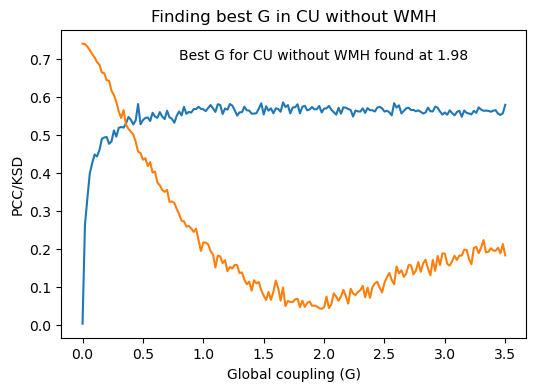

In [21]:
plot_save_cu_no_wmh()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

-0.02 vs. -0.021: Mann-Whitney-Wilcoxon test two-sided, P_val:9.056e-21 U_stat=6.207e+05


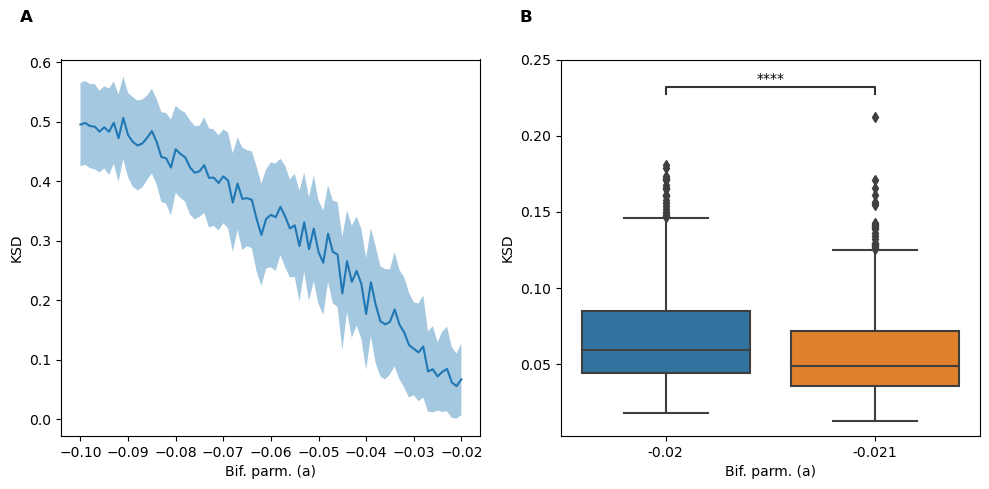

In [5]:
plot_save_mci_no_wmh(n_rep=n_simulations)

In [6]:
#Load the data
df_cu_wmh_all_model_fits, df_mci_wmh_all_model_fits = load_wmh_groups_all_model_phfcd()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Base vs. Homog. a: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.695e-02 U_stat=5.308e+05
Homog. a vs. Homog. G: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.160e-05 U_stat=5.566e+05
Base vs. Homog. G: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.734e-11 U_stat=5.860e+05
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Base vs. Homog. a: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.755e-289 U_stat=9.694e+05
Homog. a vs. Homog. G: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.043e-43

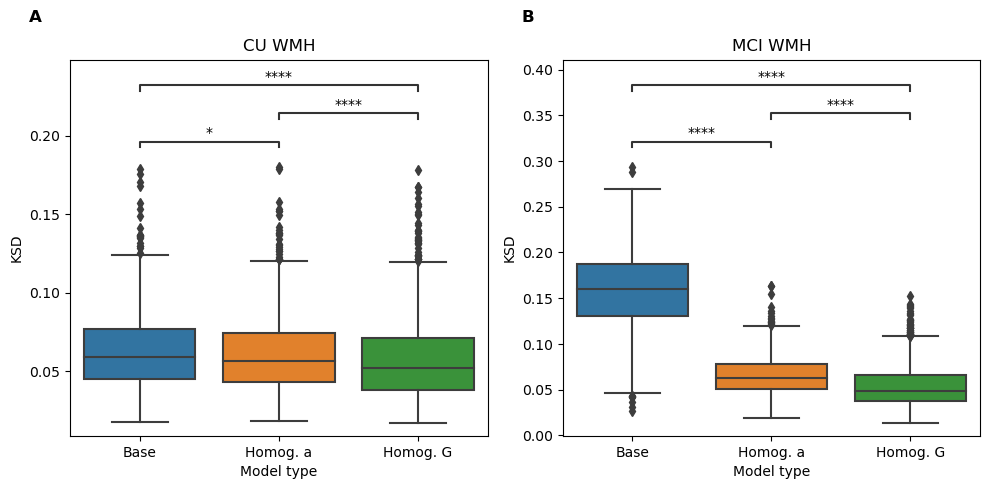

In [7]:
plot_and_save_wmh_groups_model_phfcd_comparison(df_cu_wmh_all_model_fits, df_mci_wmh_all_model_fits) 